In [15]:
import torch
from torch.utils.data import DataLoader
from torch import nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import skimage
import importlib
from tqdm import tqdm

from torchvision.models import resnet18, ResNet18_Weights
from timm import create_model
import torch.nn.functional as F

import folded_dataset
# reload(folded_dataset)

In [2]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 24.0
    Uninstalling pip-24.0:
      Successfully uninstalled pip-24.0
Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


In [17]:
# make sure to add your own directory for data directory (i.e. root directory) and feature directory

root_dir = '/scr/nnair/dataset/CHAMMI'
feature_dir = '/scr/nnair/all_features'

In [19]:
def configure_dataset(root_dir, dataset_name):
    df_path = f'{root_dir}/{dataset_name}/enriched_meta.csv'
    df = pd.read_csv(df_path)
    dataset = folded_dataset.SingleCellDataset(csv_file=df_path, root_dir=root_dir, target_labels='train_test_split')

    return dataset

In [20]:
def get_save_features(model, feature_dir, feature_file, root_dir, model_check):
    dataset_names = ['CP','Allen','HPA']
    for dataset_name in dataset_names:
        dataset = configure_dataset(root_dir, dataset_name)
        train_dataloader = DataLoader(dataset, batch_size=256, shuffle=False)
        if model_check == "resnet":
            preprocess = weights.transforms()
        all_feat = []
        for images, label in tqdm(train_dataloader, total=len(train_dataloader)):
            cloned_images = images.clone()
            batch_feat = []
            for i in range(cloned_images.shape[1]):
                # Copy each channel three times 
                channel = cloned_images[:, i, :, :]
                channel = channel.unsqueeze(1)
                expanded = channel.expand(-1, 3, -1, -1).to(device)
        
                if model_check == "resnet":
                    expanded = preprocess(expanded).to(device)
                    feat_temp = feature_extractor(expanded).cpu().detach().numpy()
                else: 
                    feat_temp = forward(expanded).cpu().detach().numpy()
                    
                batch_feat.append(feat_temp)
                
            batch_feat = np.concatenate(batch_feat, axis=1)
            all_feat.append(batch_feat)
       
        all_feat = np.concatenate(all_feat)
        all_feat = all_feat.squeeze(2).squeeze(2)
        feature_path = feature_path = f'{feature_dir}/{dataset_name}/{feature_file}'
        np.save(feature_path, all_feat)


## Convnext Feature Extraction

In [147]:
from timm import create_model
import torch.nn.functional as F

In [148]:
def forward(x: torch.Tensor) -> torch.Tensor:
    x = feature_extractor(x)
    if pooling == 'avg':
        x = F.adaptive_avg_pool2d(x, (1, 1))
    elif pooling == 'max':
        x = F.adaptive_max_pool2d(x, (1, 1))
    elif pooling == 'avg_max':
        x_avg = F.adaptive_avg_pool2d(x, (1, 1))
        x_max = F.adaptive_max_pool2d(x, (1, 1))
        x = torch.cat([x_avg, x_max], dim=1)
    elif pooling == None:
        pass
    else:
        raise ValueError(
            f"Pooling {self.cfg.pooling} not supported. Use one of {FeaturePooling.list()}"
        )
    # x = rearrange(x, "b c h w -> b (c h w)")
    return x

In [149]:
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

In [21]:
feature_file = 'pretrained_convnext_channel_replicate.npy'
pooling = 'avg'

In [151]:
pretrained = True
model = create_model("convnext_tiny.fb_in22k", pretrained=pretrained).to(device)
feature_extractor = nn.Sequential(
                    model.stem,
                    model.stages[0],
                    model.stages[1],
                    model.stages[2].downsample,
                    *[model.stages[2].blocks[i] for i in range(9)],
                    model.stages[3].downsample,
                    *[model.stages[3].blocks[i] for i in range(3)],
                )

100%|███████████████████████████████████| 262/262 [5:44:54<00:00, 78.99s/it]


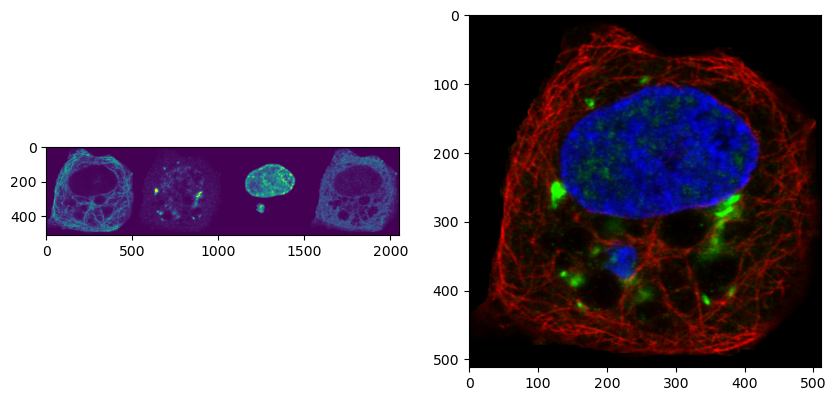

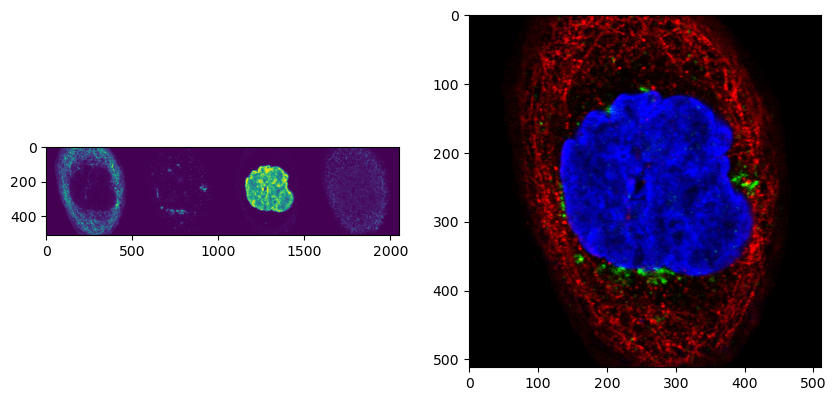

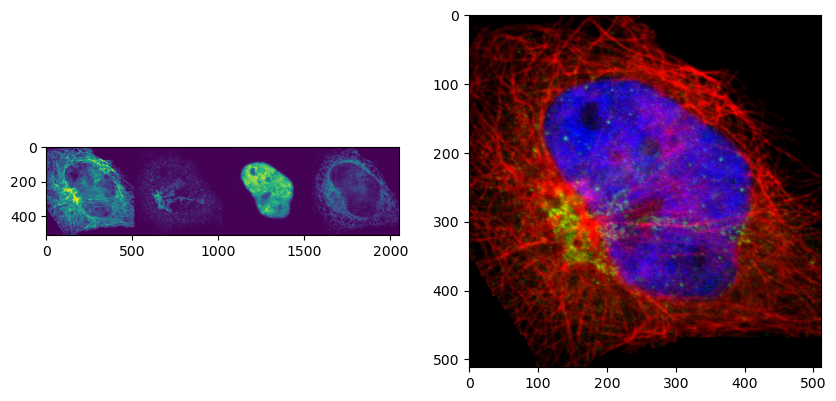

In [152]:
model_check = "convnext"
get_save_features(model, feature_dir, feature_file, root_dir, model_check)

## ResNet Feature Extraction

In [7]:
from torchvision.models import resnet18, ResNet18_Weights

In [8]:
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

In [22]:
feature_file = 'pretrained_resnet18_features.npy'

In [10]:
weights = ResNet18_Weights.IMAGENET1K_V1
m = resnet18(weights=weights).to(device)
feature_extractor = torch.nn.Sequential(*list(m.children())[:-1]).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/MORGRIDGE/nnair/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████| 44.7M/44.7M [00:00<00:00, 95.9MB/s]


100%|█████████████████████████████████████| 262/262 [23:23<00:00,  5.36s/it]


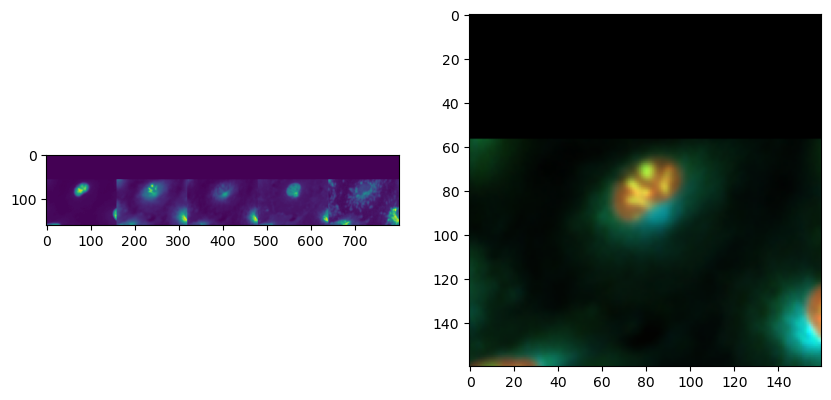

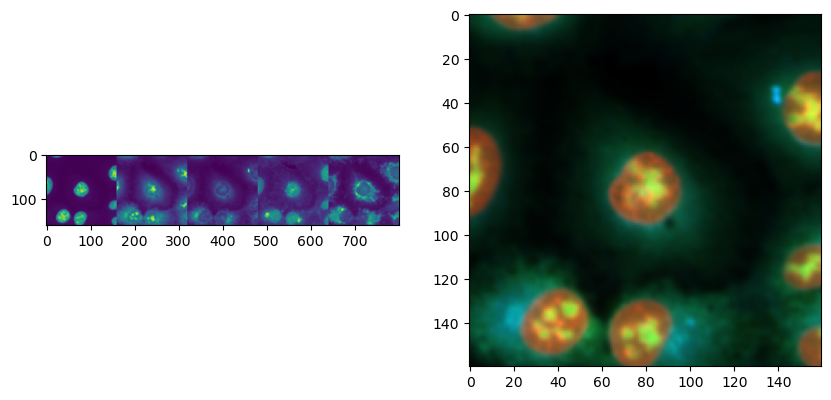

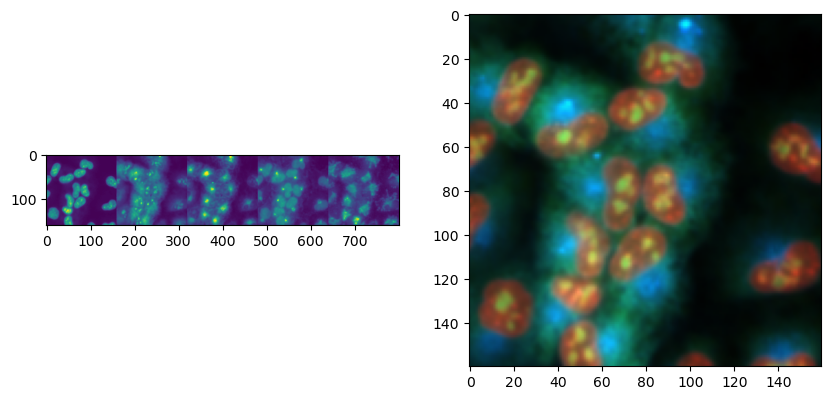

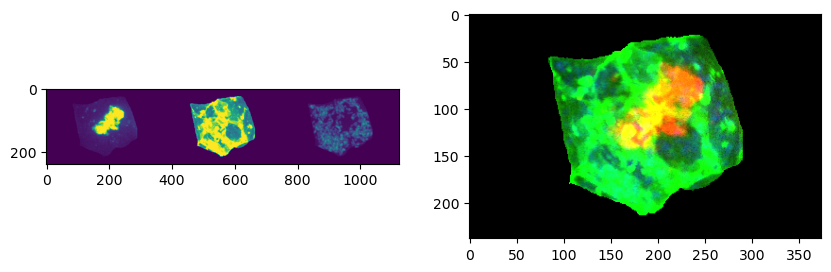

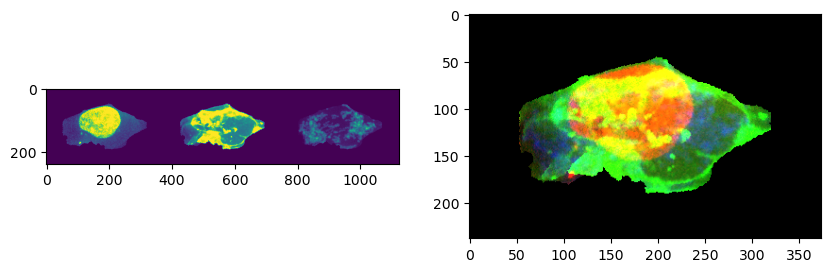

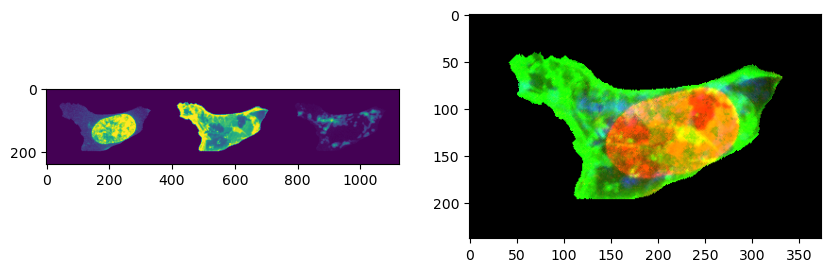

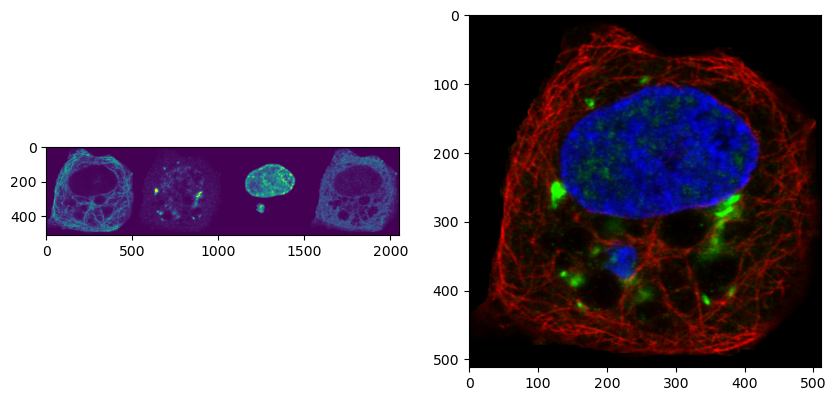

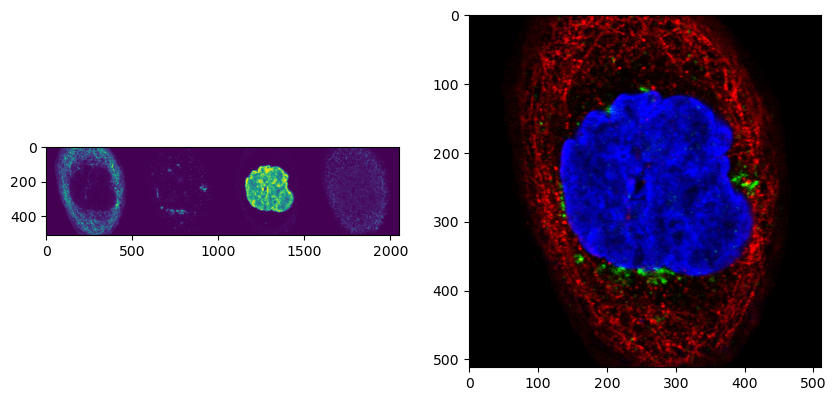

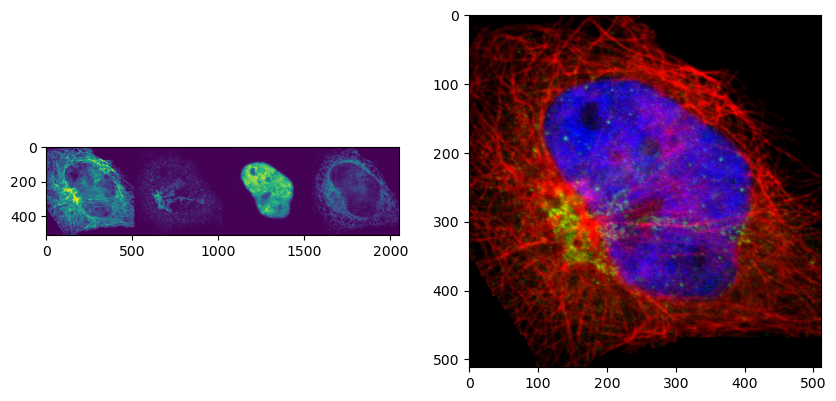

In [12]:
model_check = "resnet"
get_save_features(m, feature_dir, feature_file, root_dir, model_check)